# TwoStream Classifier

In [1]:
import os
import shutil
import pandas as pd
import numpy as np
from numpy import asarray
import cv2 as cv
import re
import math
from subprocess import check_call, PIPE, Popen
import shlex

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
from PIL import Image
from torchvision import models
from torch import nn
import torcheval
from torcheval.metrics.functional import multiclass_auprc

## 1 Read Test, Train, and Val set

In [3]:
upperlimit = 500
cutoff = 406

In [4]:
train = pd.read_pickle("data/noor2/CorpusNGT/train_cutoff{}_upperlimit{}.pkl".format(cutoff, upperlimit))
test  = pd.read_pickle("data/noor2/CorpusNGT/test_cutoff{}_upperlimit{}.pkl".format(cutoff, upperlimit))
val   = pd.read_pickle("data/noor2/CorpusNGT/validate_cutoff{}_upperlimit{}.pkl".format(cutoff, upperlimit))

In [5]:
tr = (train["id"]).unique() ## So there are 157 classes in this dataset of which each have about
va = (val["id"]).unique()
te = (test["id"]).unique()
total = np.concatenate((tr, va, te), axis=0, out=None)
total = np.unique(total)
total = np.sort(total)
print(len(total))
print(len(train))                ## 156.5 instances per class on average.

20
7477


In [6]:
catgs = total
num_classes = len(catgs)
labels_dict = {}
ind = 0
for uc in catgs:
    labels_dict[uc] = ind
    ind+=1

def preprocess_datasubset(split):
    split_labels = split["id"].tolist()
    split_ids = split["path"].tolist()
    print(len(split_ids), len(split_labels))
    return split_ids, split_labels

train_ids, train_labels = preprocess_datasubset(train)
test_ids, test_labels = preprocess_datasubset(test)
val_ids, val_labels = preprocess_datasubset(val)

7477 7477
936 936
934 934


In [7]:
print(labels_dict)

{'1-A': 0, 'AL': 1, 'BINNEN': 2, 'GEBAREN-A': 3, 'GEHANDICAPT-A': 4, 'GOED-A': 5, 'HEE': 6, 'HOREN-A': 7, 'JA-A': 8, 'KIJKEN-A': 9, 'KUNNEN-A': 10, 'LAAT-MAAR': 11, 'MAAR': 12, 'PO': 13, 'POPT': 14, 'PT': 15, 'PV': 16, 'SAMEN-A': 17, 'ZELF': 18, 'ZELFDE-A': 19}


In [8]:
# We've now obtained the paths and labels for all sets of gloss frames that have two or more occurrences of the gloss, and split these into a test and training set

## 2 DEFINE DATASETS AND TRANSFORMS

In [9]:
# Now we have to transform the frames into usable format; tensors

In [10]:
from torch.utils.data import Dataset, DataLoader, Subset
import glob
from PIL import Image
import torch
import numpy as np
import random
from torchvision.transforms.functional import to_pil_image
import matplotlib.pylab as plt
torch.set_printoptions(sci_mode=False, precision=4)  # No scientific notation, 4 decimal places

np.random.seed(2024)
random.seed(2024)
torch.manual_seed(2024)

In [22]:
# Choose model type, this is just a test. For now we pick the R3D_18 ResNet 18 layer model from pytorch that has been pretrained on the Kinetics dataset

#model_type = "Net"
model_type = "GRU"
#model_type = "LSTM"

batch_size = 32   ## 32 is standard for 20 classes 16 for 50

h, w = 96, 2 # 75 keypoints x and y so 75 by 2.
h, w = 400, 1
# already normalized by mp so no mean needed

In [23]:
class KeyPointDataset(Dataset):
    def __init__(self, ids, labels, transform, num_keypoints=96):
        self.transform = transform
        self.ids = ids
        self.labels = labels
        self.num_keypoints = num_keypoints  # Fixed number of keypoints per frame
        self.file_paths = []  # List to store file paths for each sample

        # Precompute the file paths
        for video_id in self.ids:
            path2imgs = glob.glob(video_id + "/*.jpg")
            path2imgs = path2imgs[:8]
            self.file_paths.append(path2imgs)  # Store the list of file paths for each video


    def __len__(self):
        return len(self.ids)

    def __getitem__(self, idx):
        # Load the keypoint file
        keypointfile = pd.read_pickle(glob.glob(self.ids[idx] + "/keypoints")[0], compression='infer', storage_options=None)
        keypointfile = keypointfile[["frame", "x", "y"]]
        label = labels_dict[self.labels[idx]]  # Map the label

        # Group by frames and take only the first 8 frames
        framelist = list(keypointfile.groupby(by="frame"))[:8]

        frames = []
        for frame in framelist:
            frame_np = frame[1][["x", "y"]].to_numpy()

            # Pad or truncate each frame to num_keypoints
            if frame_np.shape[0] > self.num_keypoints:  # Truncate
                frame_np = frame_np[:self.num_keypoints, :]
            elif frame_np.shape[0] < self.num_keypoints:  # Pad with zeros
                padding = np.zeros((self.num_keypoints - frame_np.shape[0], frame_np.shape[1]))
                frame_np = np.vstack((frame_np, padding))

            frames.append(frame_np)

        # Ensure all 8 frames are present, pad with zero frames if necessary
        while len(frames) < 8:
            frames.append(np.zeros((self.num_keypoints, 3)))

        # Convert frames to tensors and stack them
        frames = torch.tensor(frames, dtype=torch.float32)  # Shape: [8, 96, 3]

        return frames, label

class VideoMAEDataset(Dataset):
    def __init__(self, ids, labels, transform, num_features=400):
        self.transform = transform
        self.ids = ids
        self.labels = labels
        self.num_features = num_features  # Fixed number of keypoints per frame
        self.file_paths = []  # List to store file paths for each sample

        # Precompute the file paths
        for video_id in self.ids:
            path2imgs = glob.glob(video_id + "/*.jpg")
            path2imgs = path2imgs[:8]
            self.file_paths.append(path2imgs)  # Store the list of file paths for each video

    def __len__(self):
        return len(self.ids)

    def __getitem__(self, idx):
        # Load the keypoint file
        loaded_features = np.load(self.ids[idx] + "/VideoMAE_Features.npz")["features"]
        loaded_features = torch.tensor(loaded_features)  # Convert back to torch if needed
        label = labels_dict[self.labels[idx]]  # Map the label
        loaded_features = normalize_globally_min_max(loaded_features).to(torch.float32)

        return loaded_features, label

def get_all_features_with_clipping(train_ids, lower_quantile=0.05, upper_quantile=0.95):
    all_features = []
    for id in train_ids:
        loaded_features = np.load(id + "/VideoMAE_Features.npz")["features"]
        loaded_features = loaded_features.flatten()
        
        # Clip outliers using the percentiles
        lower_bound = np.percentile(loaded_features, lower_quantile * 100)
        upper_bound = np.percentile(loaded_features, upper_quantile * 100)
        clipped_features = np.clip(loaded_features, lower_bound, upper_bound)
        
        all_features.extend(clipped_features.tolist())
    
    return np.array(all_features)

def get_global_min_max(all_features):
    # Compute the global min and max over all features
    global_min = np.min(all_features)
    global_max = np.max(all_features)
    return global_min, global_max

def normalize_globally_min_max(x):
    # Normalize using global min-max normalization to [-1, 1]
    normalized_x = 2 * (x - global_min) / (global_max - global_min) - 1
    return np.clip(normalized_x, -1, 1)


# Now get the features with clipping
all_features = get_all_features_with_clipping(train_ids)

# Calculate global min/max on the clipped data
global_min, global_max = get_global_min_max(all_features)
print(f"Clipped Global Min: {global_min}, Clipped Global Max: {global_max}")

Clipped Global Min: -2.0625, Clipped Global Max: 2.228515625


TRAIN

In [24]:
train_transformer_keypoints = transforms.Compose([
            transforms.ToTensor()
            ])

train_transformer_videoMAE = transforms.Compose([
            ])


train_ds_keypoints = KeyPointDataset(ids= train_ids, labels= train_labels, transform= train_transformer_keypoints)
print(len(train_ds_keypoints))

train_ds_mae = VideoMAEDataset(ids= train_ids, labels= train_labels, transform=train_transformer_videoMAE)
print(len(train_ds_mae))

print(train_ds_keypoints)
print(train_ds_mae)


7477
7477


In [25]:
# inspect to make sure both dataset objects have same label order. They do!
imgs_keypoints, label_keypoints = train_ds_keypoints[12]
imgs_mae, label_mae = train_ds_mae[12]

print(label_mae)
print(label_keypoints)   

print(imgs_mae)

13
13
tensor([     0.1758,      1.0000,      0.9131,      0.1641,     -0.3403,
             0.1533,      0.1172,     -0.6963,     -0.3208,     -0.6924,
            -0.4258,      0.0137,      0.2900,     -0.2637,     -0.2451,
            -0.5098,      0.6201,     -0.6934,     -0.0718,      0.3555,
            -0.0605,      0.4404,      0.2002,     -0.0776,      0.2979,
            -0.1665,     -0.4595,     -0.0332,      0.0596,     -0.1343,
            -0.2690,      0.7607,     -0.6074,     -0.3267,      0.6621,
            -0.5137,      0.0410,     -0.1577,     -0.6191,     -0.9365,
             0.0674,     -0.3735,      0.2197,      0.0938,     -0.5366,
             0.0684,     -0.0737,     -0.4629,      0.0859,     -0.0396,
             0.1250,     -0.0488,     -0.1538,     -0.3452,     -0.1304,
             0.0713,     -0.1992,      1.0000,     -0.4673,     -0.0195,
            -0.1553,     -0.2202,     -0.7896,     -0.2515,     -0.0703,
            -0.1997,     -0.2383,      0.1787

In [26]:
from torch.utils.data import Dataset, DataLoader

class CombinedDataset(Dataset):
    def __init__(self, keypoint_ds, mae_ds):
        self.keypoint_ds = keypoint_ds
        self.mae_ds = mae_ds
        self.file_paths = keypoint_ds.file_paths #+ mae_dataset.file_paths  # Combine file paths from both datasets

        assert len(keypoint_ds) == len(mae_ds), "Datasets must have the same length"

    def __len__(self):
        return len(self.keypoint_ds)

    def __getitem__(self, idx):
        keypoints, label_kp = self.keypoint_ds[idx]
        mae_features, label_mae = self.mae_ds[idx]
        
        assert label_kp == label_mae, "Labels should match between datasets"
        
        return keypoints, mae_features, label_kp  # Return both features and label

# Instantiate the combined dataset
combined_train_dataset = CombinedDataset(train_ds_keypoints, train_ds_mae)


In [27]:
# Ensure train, val, and test sets have no common samples
if len(set(train_ids) & set(test_ids)) == 0:
    print("no leakage")
if len(set(train_ids) & set(val_ids)) == 0:
     print("no leakage")
if len(set(val_ids) & set(test_ids)) == 0:
     print("no leakage")


no leakage
no leakage
no leakage


TEST and VAL

In [28]:

test_transformer_keypoints = transforms.Compose([
            transforms.ToTensor()
            ])

test_transformer_videoMAE = transforms.Compose([
            ])

test_ds_keypoints = KeyPointDataset(ids= test_ids, labels= test_labels, transform= test_transformer_keypoints)
print(len(test_ds_keypoints))
val_ds_keypoints = KeyPointDataset(ids= val_ids, labels= val_labels, transform= test_transformer_keypoints)
print(len(val_ds_keypoints))

test_ds_mae = VideoMAEDataset(ids= test_ids, labels= test_labels, transform=test_transformer_videoMAE)
print(len(test_ds_mae))
val_ds_mae = VideoMAEDataset(ids= val_ids, labels= val_labels, transform=test_transformer_videoMAE)
print(len(val_ds_mae))

# Instantiate the combined dataset
combined_test_dataset = CombinedDataset(test_ds_keypoints, test_ds_mae)
combined_val_dataset = CombinedDataset(val_ds_keypoints, val_ds_mae)

936
934
936
934


## 3 DEFINE DATALOADER

We define the custom dataloader for our model; batch and stack the images etc

In [29]:
# Use a single DataLoader for training
train_loader = DataLoader(combined_train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(combined_test_dataset, batch_size=32, shuffle=False)
val_loader = DataLoader(combined_val_dataset, batch_size=32, shuffle=False)

In [30]:
for xk,xv,yb in train_loader:
    print(xk.shape, xv.shape, yb.shape)
    break

torch.Size([32, 8, 96, 2]) torch.Size([32, 400]) torch.Size([32])


## 4 DEFINE MODEL

In [31]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [32]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Sign Adaptor for fusion
class SignAdaptor(nn.Module):
    def __init__(self, keypoint_in_dim, videoMAE_in_dim, out_dim):
        super(SignAdaptor, self).__init__()
        
        # Linear Projections for both feature types
        self.keypoint_projection = nn.Linear(keypoint_in_dim, 512)  # Adjust size as needed
        self.videoMAE_projection = nn.Linear(videoMAE_in_dim, 512)  # Adjust size as needed
        
        # C layer (concatenate both and apply linear transformation)
        self.c_layer = nn.Linear(512 + 512, 512)  # Assuming concatenation of both
        
        # 1D TCN (Temporal Convolution Network)
        self.tcn = nn.Sequential(
            nn.Conv1d(in_channels=512, out_channels=512, kernel_size=3, padding=1), 
            nn.ReLU(), 
            nn.Conv1d(in_channels=512, out_channels=512, kernel_size=3, padding=1)
        )
        
        # Final Layers
        self.final_fc1 = nn.Linear(512, 512)
        self.gelu = nn.GELU()
        self.final_fc2 = nn.Linear(512, out_dim)
    
    def forward(self, keypoint_features, videoMAE_features):

        batch_size, frames, height, width = keypoint_features.shape
        keypoint_features = keypoint_features.view(batch_size, -1)  # Fully flatten frames, height, and width
        
        # Linear projections
        keypoint_proj = self.keypoint_projection(keypoint_features)
        videoMAE_proj = self.videoMAE_projection(videoMAE_features)
        
        # Concatenate projections
        combined = torch.cat((keypoint_proj, videoMAE_proj), dim=-1)
        
        # C layer
        c_out = self.c_layer(combined)
        
        # TCN - needs to be reshaped if necessary to fit the TCN input shape
        c_out = c_out.unsqueeze(1).transpose(1, 2)  # Shape (batch_size, 1, feature_size)
        tcn_out = self.tcn(c_out)
        
        # Flatten and pass through final MLP
        tcn_out = tcn_out.mean(dim=2)  # Average pooling over the temporal dimension to reduce [batch, 512, seq_len] -> [batch, 512]
        # Pass through final fully connected layers
        fc_out = self.final_fc1(tcn_out)
        fc_out = self.gelu(fc_out)
        output = self.final_fc2(fc_out)

        return output


# LSTM + SignAdaptor for Keypoints
class LSTM_with_SignAdaptor(nn.Module):
    def __init__(self, params_model):
        super(LSTM_with_SignAdaptor, self).__init__()
        
        # Set up the parameters from the passed dictionary
        self.lstm_input_size = params_model["lstm_input_size"]  # This should be 1024
        self.lstm_keypoint_input_size = params_model["lstm_keypoint_input_size"]  # This should be 1024
        self.lstm_MAE_input_size = params_model["lstm_MAE_input_size"]  # This should be 1024
        self.lstm_hidden_size = params_model["lstm_hidden_size"]
        self.lstm_num_layers = params_model["lstm_num_layers"]
        self.num_classes = params_model["num_classes"]
        self.drop_p = params_model["drop_p"]
        
        # SignAdaptor layer
        self.sign_adaptor = SignAdaptor(keypoint_in_dim=self.lstm_keypoint_input_size, videoMAE_in_dim=self.lstm_MAE_input_size, out_dim=self.lstm_hidden_size)
        
        # LSTM layer
        self.lstm = nn.LSTM(
            input_size=self.lstm_hidden_size,  # This is the output size of the SignAdaptor
            hidden_size=self.lstm_hidden_size,
            num_layers=self.lstm_num_layers,
            batch_first=True,
        )
        
        # Final Classifier layers
        self.fc1 = nn.Linear(self.lstm_hidden_size, 512)
        self.fc2 = nn.Linear(512, self.num_classes)
    
    def forward(self, keypoint_data, videoMAE_data):
        # Process keypoint and videoMAE data through SignAdaptor (fusing both features)
        combined_out = self.sign_adaptor(keypoint_data, videoMAE_data)
        
        # Pass the fused features through LSTM
        batch_size, features = combined_out.shape
        self.lstm.flatten_parameters()
        lstm_out, (h_n, c_n) = self.lstm(combined_out)
        
        # Final classification
        out = F.relu(self.fc1(lstm_out))
        out = F.dropout(out, p=self.drop_p, training=self.training)
        out = self.fc2(out)
        
        return out


# GRU + SignAdaptor for Keypoints and VideoMAE data
class GRU_with_SignAdaptor(nn.Module):
    def __init__(self, params_model):
        super(GRU_with_SignAdaptor, self).__init__()
        
        # Set up the parameters from the passed dictionary
        self.gru_keypoint_input_size = params_model["gru_keypoint_input_size"]  # This should be 1024
        self.gru_MAE_input_size = params_model["gru_MAE_input_size"]  # This should be 1024
        self.gru_input_size = params_model["gru_input_size"]  # This should be 1024
        self.gru_hidden_size = params_model["gru_hidden_size"]
        self.gru_num_layers = params_model["gru_num_layers"]
        self.num_classes = params_model["num_classes"]
        self.drop_p = params_model["drop_p"]
        
        # SignAdaptor layer
        self.sign_adaptor = SignAdaptor(keypoint_in_dim=self.gru_keypoint_input_size, videoMAE_in_dim=self.gru_MAE_input_size, out_dim=self.gru_hidden_size)
        
        # GRU layer
        self.gru = nn.GRU(
            input_size=self.gru_hidden_size,  # This is the output size of the SignAdaptor
            hidden_size=self.gru_hidden_size,
            num_layers=self.gru_num_layers,
            batch_first=True,
        )
        
        # Final Classifier layers
        self.fc1 = nn.Linear(self.gru_hidden_size, 512)
        self.fc2 = nn.Linear(512, self.num_classes)
    
    def forward(self, keypoint_data, videoMAE_data):
        # Process keypoint and videoMAE data through SignAdaptor (fusing both features)
        combined_out = self.sign_adaptor(keypoint_data, videoMAE_data)
        
        # Pass the fused features through GRU
        batch_size, features = combined_out.shape
        self.gru.flatten_parameters()
        gru_out, hidden = self.gru(combined_out)
        
        # Final classification
        out = F.relu(self.fc1(gru_out))
        out = F.dropout(out, p=self.drop_p, training=self.training)
        out = self.fc2(out)
        
        return out


# Model Selection
if model_type == "LSTM":
    params_model = {
        "num_classes": num_classes,
        "drop_p": 0.0,
        "pretrained": False,
        "lstm_hidden_size": 512,
        "lstm_keypoint_input_size": 8*96*2,  # Corrected input size after SignAdaptor fusion
        "lstm_MAE_input_size": 400,  # Corrected input size after SignAdaptor fusion
        "lstm_input_size": 1024,  # Corrected input size after SignAdaptor fusion
        "lstm_num_layers": 3,
    }
    model = LSTM_with_SignAdaptor(params_model)

    epochs = 200  # 500
    log_interval = 20  # 20
    num_classes = num_classes
    input_size = 1024  # not relevant
    hidden_size = 512
    num_layers = 1
    hidden1 = 512
    drop_p = 0.0

elif model_type == "GRU":
    params_model = {
        "num_classes": num_classes,
        "drop_p": 0.0,
        "pretrained": False,
        "gru_hidden_size": 512,
        "gru_keypoint_input_size": 8*96*2,  # Corrected input size after SignAdaptor fusion
        "gru_MAE_input_size": 400,  # Corrected input size after SignAdaptor fusion
        "gru_input_size": 1024,  # Corrected input size after SignAdaptor fusion
        "gru_num_layers": 3,
    }
    model = GRU_with_SignAdaptor(params_model)
    
    epochs = 200  # 500
    log_interval = 20  # 20
    num_classes = num_classes
    input_size = 1024  # not relevant
    hidden_size = 512
    num_layers = 1
    hidden1 = 512
    drop_p = 0.0


In [33]:
with torch.no_grad():
    x1 = torch.zeros(batch_size, 8, 96, 2)
    x2 = torch.zeros(batch_size, 400)
    y= model(x1, x2)
    print(y.shape)
    print(x1.shape)
    print(x2.shape)

torch.Size([32, 20])
torch.Size([32, 8, 96, 2])
torch.Size([32, 400])


In [34]:
model = model.to(device)

In [35]:
model

GRU_with_SignAdaptor(
  (sign_adaptor): SignAdaptor(
    (keypoint_projection): Linear(in_features=1536, out_features=512, bias=True)
    (videoMAE_projection): Linear(in_features=400, out_features=512, bias=True)
    (c_layer): Linear(in_features=1024, out_features=512, bias=True)
    (tcn): Sequential(
      (0): Conv1d(512, 512, kernel_size=(3,), stride=(1,), padding=(1,))
      (1): ReLU()
      (2): Conv1d(512, 512, kernel_size=(3,), stride=(1,), padding=(1,))
    )
    (final_fc1): Linear(in_features=512, out_features=512, bias=True)
    (gelu): GELU(approximate='none')
    (final_fc2): Linear(in_features=512, out_features=512, bias=True)
  )
  (gru): GRU(512, 512, num_layers=3, batch_first=True)
  (fc1): Linear(in_features=512, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=20, bias=True)
)

In [36]:
device

device(type='cuda')

## 5 TRAIN MODEL

##### New

In [37]:
import torch
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import traceback

def calculate_metrics(preds, labels, num_classes):
    """
    Calculate overall and per-class precision and recall.
    Precision: TP / (TP + FP)
    Recall: TP / (TP + FN)
    """
    per_class_correct = torch.zeros(num_classes, device=preds.device)  # True Positives (TP)
    per_class_predicted = torch.zeros(num_classes, device=preds.device)  # TP + FP
    per_class_actual = torch.zeros(num_classes, device=preds.device)  # TP + FN

    for cls in range(num_classes):
        tp = ((preds == cls) & (labels == cls)).sum().float()  # True Positives
        total_pred = (preds == cls).sum().float()  # TP + FP
        total_actual = (labels == cls).sum().float()  # TP + FN

        per_class_correct[cls] = tp
        per_class_predicted[cls] = total_pred
        per_class_actual[cls] = total_actual

    # Compute per-class precision and recall
    per_class_precision = per_class_correct / (per_class_predicted + 1e-8)  # TP / (TP + FP)
    per_class_recall = per_class_correct / (per_class_actual + 1e-8)  # TP / (TP + FN)

    # Overall metrics
    overall_precision = per_class_correct.sum() / (per_class_predicted.sum() + 1e-8)
    overall_recall = per_class_correct.sum() / (per_class_actual.sum() + 1e-8)

    return overall_precision.item(), per_class_precision.cpu().numpy(), overall_recall.item(), per_class_recall.cpu().numpy()



def train_model_with_metrics(
    model, train_dl_combined, val_dl_combined,
    criterion, optimizer, device, num_epochs, num_classes, path2weights, lr_scheduler=None
):
    train_loss, val_loss = [], []
    train_acc, val_acc = [], []
    train_precision, val_precision = [], []
    train_recall, val_recall = [], []
    train_precision_per_class, val_precision_per_class = [], []
    train_recall_per_class, val_recall_per_class = [], []

    try:
        for epoch in range(num_epochs):
            print(f"Epoch {epoch+1}/{num_epochs}")

            # Training phase
            model.train()
            running_loss, correct_preds, total_preds = 0.0, 0, 0
            all_preds, all_labels = [], []

            for (inputs_kp, inputs_mae, labels) in tqdm(
                train_dl_combined,
                total=len(train_dl_combined),
                desc=f"Epoch {epoch+1}/{num_epochs} - Training"
            ):
                inputs_kp, inputs_mae, labels = inputs_kp.to(device), inputs_mae.to(device), labels.to(device)
                
                optimizer.zero_grad()
                outputs = model(inputs_kp, inputs_mae)

                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

                running_loss += loss.item() * inputs_mae.size(0)
                preds = torch.argmax(outputs, dim=1)

                correct_preds += (preds == labels).sum().item()
                total_preds += labels.size(0)

                all_preds.append(preds.cpu())
                all_labels.append(labels.cpu())

            # Compute metrics
            all_preds, all_labels = torch.cat(all_preds), torch.cat(all_labels)
            train_precision_epoch, train_prec_per_cls, train_recall_epoch, train_rec_per_cls = calculate_metrics(all_preds, all_labels, num_classes)

            epoch_train_loss = running_loss / len(train_dl_combined.dataset)
            epoch_train_acc = correct_preds / total_preds

            train_loss.append(epoch_train_loss)
            train_acc.append(epoch_train_acc)
            train_precision.append(train_precision_epoch)
            train_recall.append(train_recall_epoch)
            train_precision_per_class.append(train_prec_per_cls)
            train_recall_per_class.append(train_rec_per_cls)

            # Validation phase
            model.eval()
            running_loss, correct_preds, total_preds = 0.0, 0, 0
            all_preds, all_labels = [], []

            with torch.no_grad():
                for (inputs_kp, inputs_mae, labels) in tqdm(
                    val_dl_combined,
                    total=len(val_dl_combined),
                    desc=f"Epoch {epoch+1}/{num_epochs} - Validation"
                ):
                    inputs_kp, inputs_mae, labels = inputs_kp.to(device), inputs_mae.to(device), labels.to(device)

                    outputs = model(inputs_kp, inputs_mae)
                    loss = criterion(outputs, labels)

                    running_loss += loss.item() * inputs_mae.size(0)
                    preds = torch.argmax(outputs, dim=1)

                    correct_preds += (preds == labels).sum().item()
                    total_preds += labels.size(0)

                    all_preds.append(preds.cpu())
                    all_labels.append(labels.cpu())

            # Compute metrics
            all_preds, all_labels = torch.cat(all_preds), torch.cat(all_labels)
            val_precision_epoch, val_prec_per_cls, val_recall_epoch, val_rec_per_cls = calculate_metrics(all_preds, all_labels, num_classes)

            epoch_val_loss = running_loss / len(val_dl_combined.dataset)
            epoch_val_acc = correct_preds / total_preds

            val_loss.append(epoch_val_loss)
            val_acc.append(epoch_val_acc)
            val_precision.append(val_precision_epoch)
            val_recall.append(val_recall_epoch)
            val_precision_per_class.append(val_prec_per_cls)
            val_recall_per_class.append(val_rec_per_cls)

            # Adjust LR scheduler
            if lr_scheduler:
                lr_scheduler.step(epoch_val_loss)

            # Logging
            print(f"Train Loss: {epoch_train_loss:.4f}, Acc: {epoch_train_acc:.4f}, Prec: {train_precision_epoch:.4f}, Recall: {train_recall_epoch:.4f}")
            print(f"Val Loss: {epoch_val_loss:.4f}, Acc: {epoch_val_acc:.4f}, Prec: {val_precision_epoch:.4f}, Recall: {val_recall_epoch:.4f}")

            if epoch % log_interval == 0:  # Save weights every 5 epochs
                torch.save(model.state_dict(), path2weights + "/" + f"epoch{epoch}")
                print(f"Model weights saved for epoch {epoch}.")

    except Exception as e:
        print(f"Error during training: {e}")
        print(traceback.format_exc())  # Prints the full traceback

    return train_loss, val_loss, train_acc, val_acc, train_precision, val_precision, train_precision_per_class, val_precision_per_class, train_recall, val_recall, train_recall_per_class, val_recall_per_class


In [41]:
modelweights = "data/noor2/Models/Combined_GRU_fix_2"
num_epochs = 101
learning_rate = 3e-5
modelname = model_type
try:
    os.makedirs(modelweights)
except:
    print("folder already exists, you've already trained a model with this name")
torch.save(model.state_dict(), (modelweights + "/epoch0"))

print(num_classes)

folder already exists, you've already trained a model with this name
20


In [42]:
import pickle

# Load from the pickle file
with open(modelweights + "/" + "metrics.pkl", "rb") as f:
    loaded_metrics = pickle.load(f)

# Unpack the dictionary into individual variables
train_loss = loaded_metrics["train_loss"]
val_loss = loaded_metrics["val_loss"]
train_acc = loaded_metrics["train_acc"]
val_acc = loaded_metrics["val_acc"]
train_precision = loaded_metrics["train_precision"]
val_precision = loaded_metrics["val_precision"]
train_precision_per_class = loaded_metrics["train_precision_per_class"]
val_precision_per_class = loaded_metrics["val_precision_per_class"]
train_recall = loaded_metrics["train_recall"]
val_recall = loaded_metrics["val_recall"]
train_recall_per_class = loaded_metrics["train_recall_per_class"]
val_recall_per_class = loaded_metrics["val_recall_per_class"]


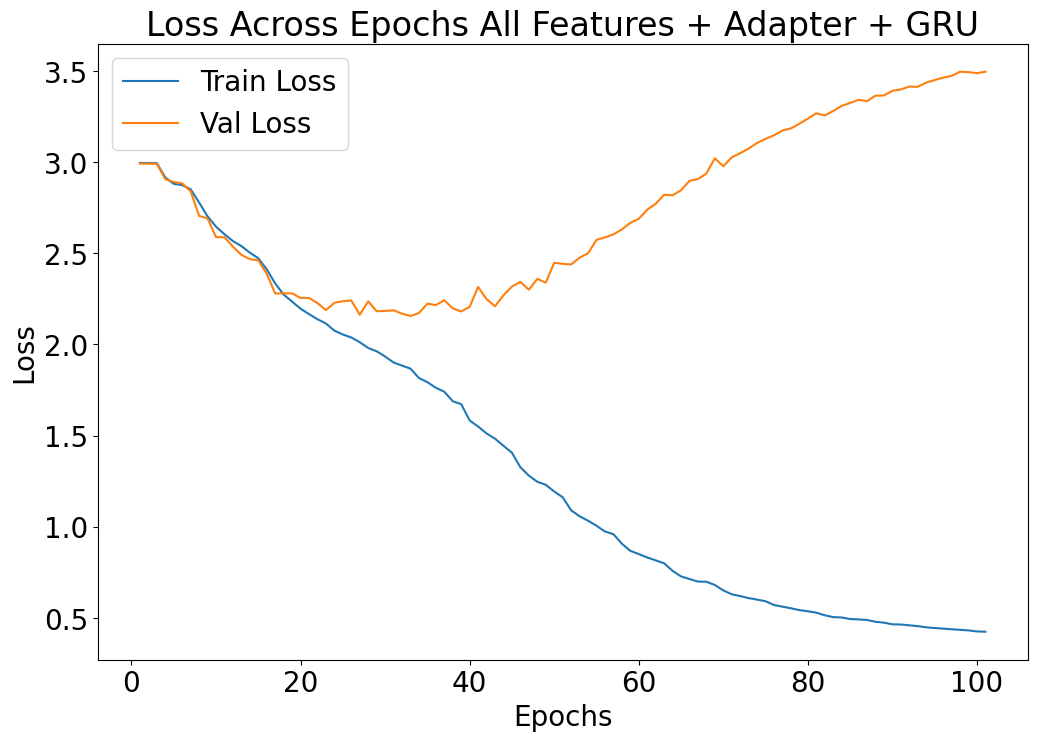

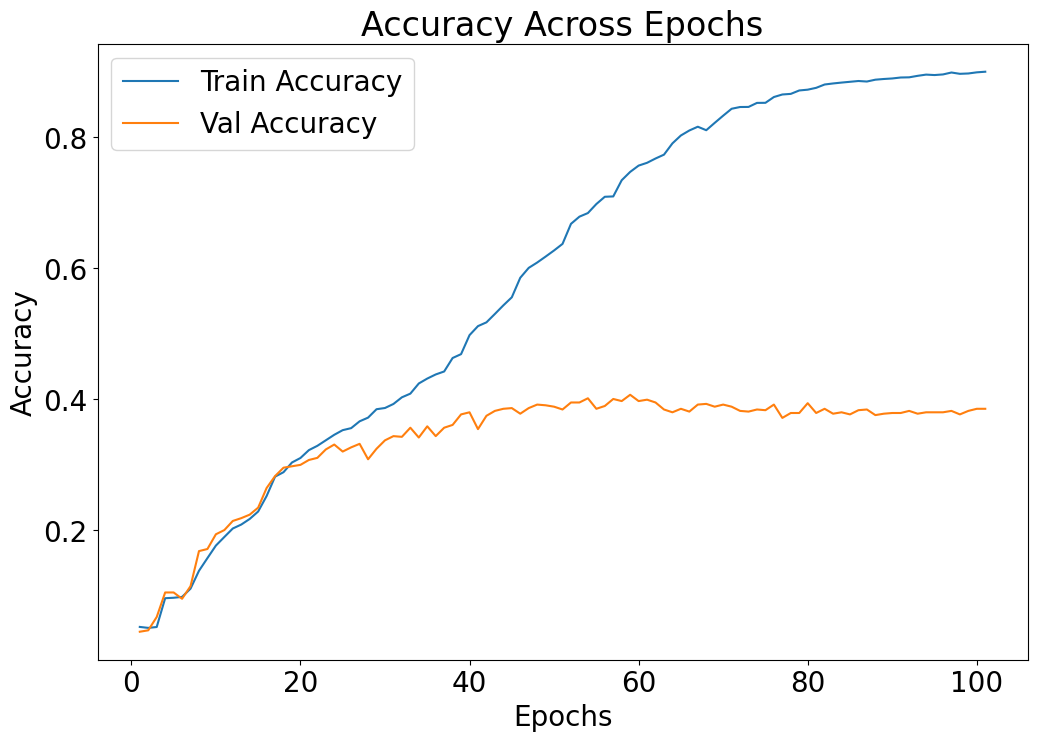

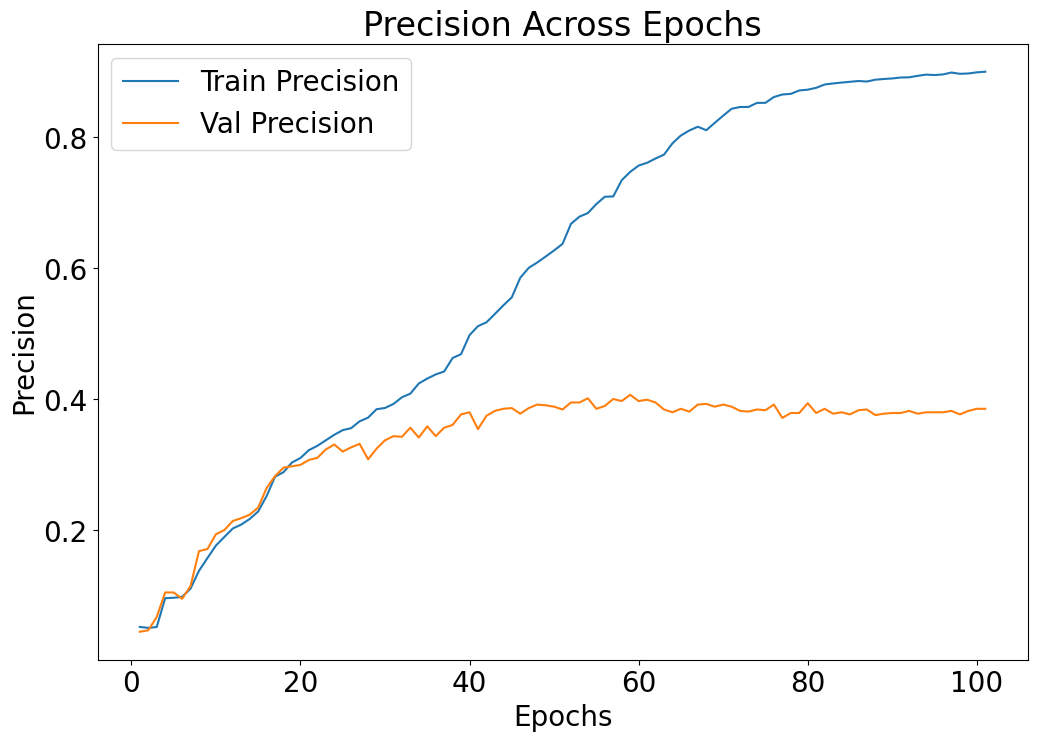

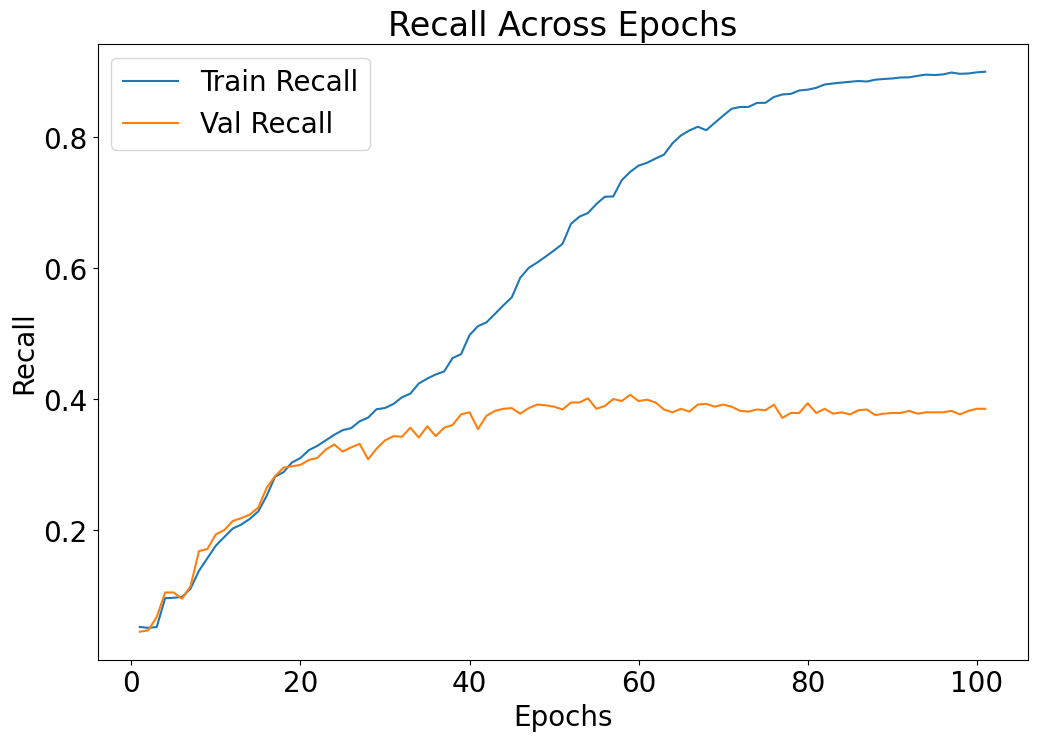

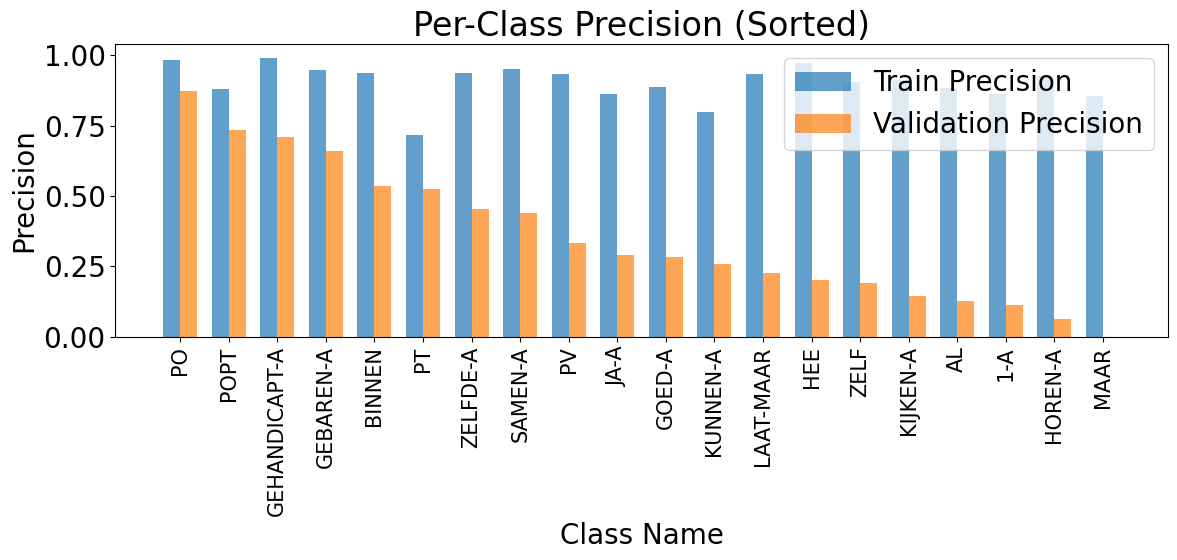

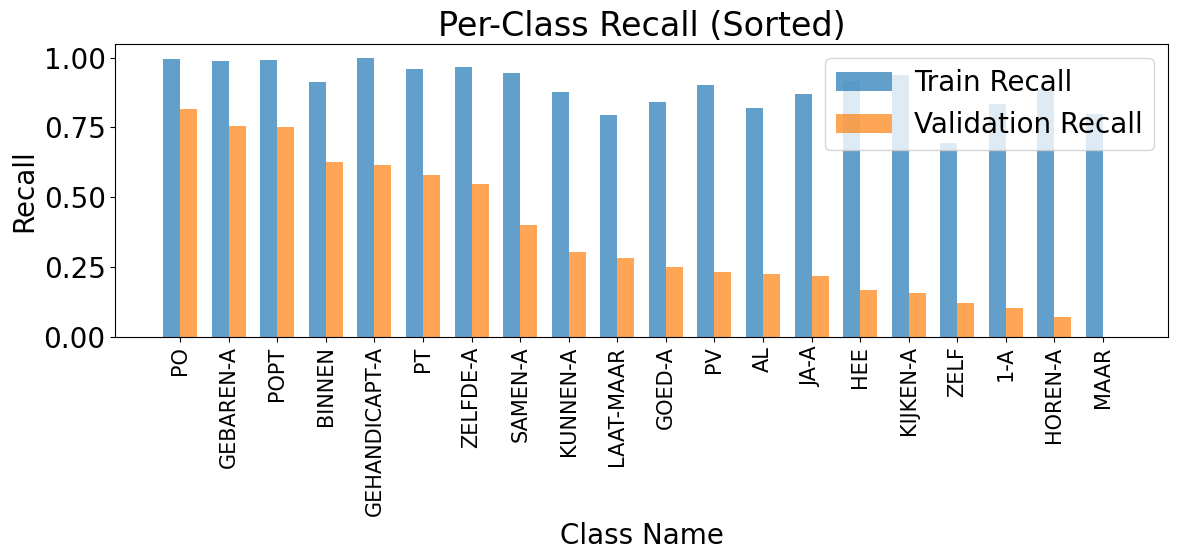

In [43]:
# Plotting results
# Plotting results for the first 101 epochs
epochs = range(1, min(num_epochs, 101) + 1)  # Ensure it doesn't exceed available epochs

plt.figure(figsize=(12, 8))
plt.rcParams['font.size'] = 20
plt.plot(epochs, train_loss[:101], label='Train Loss')  # Slice first 101 epochs
plt.plot(epochs, val_loss[:101], label='Val Loss')  # Slice first 101 epochs
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Across Epochs All Features + Adapter + ' + model_type)
plt.savefig(modelweights+'/Train-Val_Loss_First_101.png')
plt.show()

epochs = range(1, num_epochs + 1)

# Accuracy plot
plt.figure(figsize=(12, 8))
plt.plot(epochs, train_acc, label='Train Accuracy')
plt.plot(epochs, val_acc, label='Val Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy Across Epochs')
plt.savefig(modelweights+'/Train-Val Accuracy.png')
plt.show()

# Precision plot
plt.figure(figsize=(12, 8))
plt.plot(epochs, train_precision, label='Train Precision')
plt.plot(epochs, val_precision, label='Val Precision')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend()
plt.title('Precision Across Epochs')
plt.savefig(modelweights+'/Train-Val Avg Precision.png')
plt.show()

# Recall plot
plt.figure(figsize=(12, 8))
plt.plot(epochs, train_recall, label='Train Recall')
plt.plot(epochs, val_recall, label='Val Recall')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()
plt.title('Recall Across Epochs')
plt.savefig(modelweights+'/Train-Val Avg Recall.png')
plt.show()

# Plot per-class precision as histograms
last_train_precision = train_precision_per_class[-1]
last_val_precision = val_precision_per_class[-1]

bar_width = 0.35
indices = np.arange(num_classes)

sorted_indices = np.argsort(last_val_precision)[::-1]  # Sort in descending order
sorted_train_precision = np.array(last_train_precision)[sorted_indices]
sorted_val_precision = np.array(last_val_precision)[sorted_indices]
reverse_dict = {v: k for k, v in labels_dict.items()}
sorted_labels = [reverse_dict[key] for key in sorted_indices]

plt.figure(figsize=(12, 6))
plt.bar(np.arange(len(sorted_indices)), sorted_train_precision, bar_width, label='Train Precision', alpha=0.7)
plt.bar(np.arange(len(sorted_indices)) + bar_width, sorted_val_precision, bar_width, label='Validation Precision', alpha=0.7)
plt.title('Per-Class Precision (Sorted)')
plt.xlabel('Class Index' if labels_dict is None else 'Class Name')
plt.ylabel('Precision')
plt.xticks(np.arange(len(sorted_indices)) + bar_width / 2, sorted_labels, rotation=90, fontsize=15)
plt.legend()
plt.tight_layout()
plt.savefig(modelweights+'/Train-Val Precision Per Class.png')
plt.show()

# Plot per-class recall as histograms
last_train_recall = train_recall_per_class[-1]
last_val_recall = val_recall_per_class[-1]

bar_width = 0.35
indices = np.arange(num_classes)

sorted_indices = np.argsort(last_val_recall)[::-1]  # Sort in descending order
sorted_train_recall = np.array(last_train_recall)[sorted_indices]
sorted_val_recall = np.array(last_val_recall)[sorted_indices]
reverse_dict = {v: k for k, v in labels_dict.items()}
sorted_labels = [reverse_dict[key] for key in sorted_indices]

plt.figure(figsize=(12, 6))
plt.bar(np.arange(len(sorted_indices)), sorted_train_recall, bar_width, label='Train Recall', alpha=0.7)
plt.bar(np.arange(len(sorted_indices)) + bar_width, sorted_val_recall, bar_width, label='Validation Recall', alpha=0.7)
plt.title('Per-Class Recall (Sorted)')
plt.xlabel('Class Index' if labels_dict is None else 'Class Name')
plt.ylabel('Recall')
plt.xticks(np.arange(len(sorted_indices)) + bar_width / 2, sorted_labels, rotation=90, fontsize=15)
plt.legend()
plt.tight_layout()
plt.savefig(modelweights+'/Train-Val Recall Per Class.png')
plt.show()

In [44]:
#Save metrics for later
import pickle

# Combine metrics into a dictionary
metrics = {
    "train_loss": train_loss,
    "val_loss": val_loss,
    "train_acc": train_acc,
    "val_acc": val_acc,
    "train_precision": train_precision,
    "val_precision": val_precision,
    "train_precision_per_class": train_precision_per_class,
    "val_precision_per_class": val_precision_per_class,
    "train_recall": train_recall,
    "val_recall": val_recall,
    "train_recall_per_class": train_recall_per_class,
    "val_recall_per_class": val_recall_per_class
}

# Save to a pickle file
with open(modelweights + "/" + "metrics.pkl", "wb") as f:
   pickle.dump(metrics, f)

# Load from the pickle file
with open(modelweights + "/" + "metrics.pkl", "rb") as f:
    loaded_metrics = pickle.load(f)

In [45]:
print(val_acc[-1])

0.3854389721627409


----------------------

## 6 TEST MODEL

Code needs to be changed to reflect the new keypoints data type

### Test Model 2.0

In [46]:
import torch
from tqdm import tqdm
import numpy as np

def test_model(model, test_loader_combined, device, num_classes):
    model.eval()
    running_loss = 0.0
    correct_preds = 0
    total_preds = 0

    precision_per_class = np.zeros(num_classes)
    recall_per_class = np.zeros(num_classes)
    correct_per_class = np.zeros(num_classes)  # Store correct predictions per class
    total_per_class = np.zeros(num_classes)  # Store total samples per class

    criterion = torch.nn.CrossEntropyLoss()  # Assuming cross-entropy loss

    with torch.no_grad():
        for (inputs_kp, inputs_mae, labels) in tqdm(test_loader_combined, desc="Testing"):
            inputs_mae, inputs_kp, labels = inputs_mae.to(device), inputs_kp.to(device), labels.to(device)

            outputs = model(inputs_kp, inputs_mae)  # Assuming the model takes both inputs
            loss = criterion(outputs, labels)

            # Update running loss
            running_loss += loss.item() * inputs_mae.size(0)

            # Compute predictions
            preds = torch.argmax(outputs, dim=1)

            correct_preds += (preds == labels).sum().item()
            total_preds += labels.size(0)

            # Compute per-class metrics
            overall_precision, class_precision, overall_recall, class_recall = calculate_metrics(preds, labels, num_classes)
            precision_per_class += class_precision
            recall_per_class += class_recall

            # Update per-class accuracy tracking
            for i in range(num_classes):
                correct_per_class[i] += ((preds == i) & (labels == i)).sum().item()
                total_per_class[i] += (labels == i).sum().item()

    # Calculate final metrics
    test_loss = running_loss / len(test_loader_combined.dataset)
    test_acc = correct_preds / total_preds
    test_precision = precision_per_class.mean() / len(test_loader_combined)
    test_recall = recall_per_class.mean() / len(test_loader_combined)
    test_precision_per_class = precision_per_class / len(test_loader_combined)
    test_recall_per_class = recall_per_class / len(test_loader_combined)
    average_test_precision_per_class = sum(test_precision_per_class) / num_classes
    average_test_recall_per_class = sum(test_recall_per_class) / num_classes

    # Compute per-class accuracy
    accuracy_per_class = np.divide(correct_per_class, total_per_class, 
                                   out=np.zeros_like(correct_per_class, dtype=float), 
                                   where=total_per_class != 0)  # Avoid division by zero

    print(f"Test Summary:")
    print(f"Test Loss: {test_loss:.4f}, Accuracy: {test_acc:.4f}, Precision: {test_precision:.4f}, Recall: {test_recall:.4f}")
    print(f"Per-Class Precision: {test_precision_per_class}")
    print(f"Per-Class Recall: {test_recall_per_class}")
    print(f"Per-Class Accuracy: {accuracy_per_class}")

    return test_loss, test_acc, test_precision, test_precision_per_class, average_test_precision_per_class, test_recall, test_recall_per_class, average_test_recall_per_class, accuracy_per_class


In [47]:
epoch = "60"

# Choose which epoch of model weights we want to test
path_to_model_weights = modelweights + "/epoch" + epoch

# Load best model weights
model.load_state_dict(torch.load(path_to_model_weights))

# Test the model
test_loss, test_acc, test_precision, test_precision_per_class, average_test_precision_per_class, test_recall, test_recall_per_class, average_test_recall_per_class, test_accuracy_per_class = test_model(
    model, test_loader, device, num_classes)

Testing: 100%|██████████| 30/30 [00:04<00:00,  6.97it/s]

Test Summary:
Test Loss: 2.8572, Accuracy: 0.3868, Precision: 0.2775, Recall: 0.2928
Per-Class Precision: [0.11666667 0.05       0.25       0.46388889 0.64111111 0.23333334
 0.18611111 0.21666667 0.175      0.15944444 0.16777778 0.18666667
 0.05       0.69166667 0.54555556 0.40634921 0.24166667 0.41222223
 0.         0.35666667]
Per-Class Recall: [0.09722222 0.04444444 0.27777778 0.48111111 0.74055556 0.24833333
 0.17777778 0.24722222 0.15611111 0.17944445 0.19166667 0.17555556
 0.06666667 0.67777778 0.54222222 0.61111111 0.23333333 0.36111111
 0.         0.34666667]
Per-Class Accuracy: [0.14285714 0.0952381  0.42424242 0.60416667 0.93478261 0.27118644
 0.20408163 0.34       0.27659574 0.26666667 0.22916667 0.26415094
 0.08888889 0.77083333 0.71698113 0.67272727 0.34285714 0.5
 0.         0.44444444]


In [51]:
import pickle

test_metrics = {
    "test_loss": test_loss,
    "test_acc": test_acc,
    "test_precision": test_precision,
    "test_precision_per_class": test_precision_per_class,
    "average_test_precision_per_class": average_test_precision_per_class,
    "test_recall": test_recall,
    "test_recall_per_class": test_recall_per_class,
    "average_test_recall_per_class": average_test_recall_per_class,
    "test_accuracy_per_class": test_accuracy_per_class,  # Added accuracy per class
    "average_test_accuracy_per_class": sum(test_accuracy_per_class) / num_classes  # Average accuracy per class
}

# Save to a pickle file
with open(modelweights + "/" + "test_metrics" + str(epoch) + ".pkl", "wb") as f:
    pickle.dump(test_metrics, f)

# Load and verify the saved data
with open(modelweights + "/" + "test_metrics" + str(epoch) + ".pkl", "rb") as f:
    test_loaded_metrics = pickle.load(f)

print("Loaded Metrics:", test_loaded_metrics)


Loaded Metrics: {'test_loss': 2.8572111537313867, 'test_acc': 0.38675213675213677, 'test_precision': np.float64(0.2775396840522687), 'test_precision_per_class': array([0.11666667, 0.05      , 0.25      , 0.46388889, 0.64111111,
       0.23333334, 0.18611111, 0.21666667, 0.175     , 0.15944444,
       0.16777778, 0.18666667, 0.05      , 0.69166667, 0.54555556,
       0.40634921, 0.24166667, 0.41222223, 0.        , 0.35666667]), 'average_test_precision_per_class': np.float64(0.27753968405226864), 'test_recall': np.float64(0.2928055567294359), 'test_recall_per_class': array([0.09722222, 0.04444444, 0.27777778, 0.48111111, 0.74055556,
       0.24833333, 0.17777778, 0.24722222, 0.15611111, 0.17944445,
       0.19166667, 0.17555556, 0.06666667, 0.67777778, 0.54222222,
       0.61111111, 0.23333333, 0.36111111, 0.        , 0.34666667]), 'average_test_recall_per_class': np.float64(0.2928055567294359), 'test_accuracy_per_class': array([0.14285714, 0.0952381 , 0.42424242, 0.60416667, 0.93478261,

## 7 TEST MODEL Random Selector


In [54]:
import torch
from tqdm import tqdm
import numpy as np

def test_random_baseline(test_loader_combined, device, num_classes):
    running_loss = 0.0
    correct_preds = 0
    total_preds = 0
    precision_per_class = np.zeros(num_classes)
    recall_per_class = np.zeros(num_classes)
    accuracy_per_class = np.zeros(num_classes)  # Added accuracy per class
    class_counts = np.zeros(num_classes)  # To track the number of samples per class

    criterion = torch.nn.CrossEntropyLoss()  # Assuming cross-entropy loss

    with torch.no_grad():
        for (inputs_kp, inputs_mae, labels) in tqdm(test_loader_combined, desc="Testing Random Baseline"):
            labels = labels.to(device)

            # Generate random predictions based on the number of classes
            batch_size = labels.size(0)
            random_preds = torch.randint(0, num_classes, (batch_size,), device=device)

            # Compute loss (random predictions vs. actual labels)
            loss = criterion(torch.randn(batch_size, num_classes, device=device), labels)  # Use random logits

            # Update running loss
            running_loss += loss.item() * batch_size

            # Compute overall accuracy
            correct_preds += (random_preds == labels).sum().item()
            total_preds += batch_size

            # Compute per-class metrics
            overall_precision, class_precision, overall_recall, class_recall = calculate_metrics(random_preds, labels, num_classes)
            precision_per_class += class_precision
            recall_per_class += class_recall

            # Update per-class accuracy
            for i in range(num_classes):
                class_mask = (labels == i)
                class_counts[i] += class_mask.sum().item()
                accuracy_per_class[i] += (random_preds[class_mask] == labels[class_mask]).sum().item()

    # Normalize per-class accuracy
    accuracy_per_class = np.divide(accuracy_per_class, class_counts, where=class_counts > 0)

    # Calculate final metrics
    test_loss = running_loss / len(test_loader_combined.dataset)
    test_acc = correct_preds / total_preds
    test_precision = precision_per_class.mean() / len(test_loader_combined)
    test_recall = recall_per_class.mean() / len(test_loader_combined)
    test_precision_per_class = precision_per_class / len(test_loader_combined)
    test_recall_per_class = recall_per_class / len(test_loader_combined)
    average_test_precision_per_class = sum(test_precision_per_class) / num_classes
    average_test_recall_per_class = sum(test_recall_per_class) / num_classes
    average_test_accuracy_per_class = sum(accuracy_per_class) / num_classes  # Compute the average accuracy per class

    print(f"Test Summary:")
    print(f"Test Loss: {test_loss:.4f}, Accuracy: {test_acc:.4f}, Precision: {test_precision:.4f}, Recall: {test_recall:.4f}")
    print(f"Per-Class Precision: {test_precision_per_class}")
    print(f"Per-Class Recall: {test_recall_per_class}")
    print(f"Per-Class Accuracy: {accuracy_per_class}")

    return test_loss, test_acc, test_precision, test_precision_per_class, average_test_precision_per_class, test_recall, test_recall_per_class, average_test_recall_per_class, accuracy_per_class, average_test_accuracy_per_class


In [55]:
# Test the model
random_test_loss, random_test_acc, random_test_precision, random_test_precision_per_class, random_average_test_precision_per_class, random_test_recall, random_test_recall_per_class, random_average_test_recall_per_class, random_test_accuracy_per_class, random_average_test_accuracy_per_class = test_random_baseline(
    test_loader, device, num_classes
)

Testing Random Baseline: 100%|██████████| 30/30 [00:03<00:00,  7.53it/s]

Test Summary:
Test Loss: 3.4366, Accuracy: 0.0598, Precision: 0.0527, Recall: 0.0460
Per-Class Precision: [0.03611111 0.01111111 0.09444444 0.11666667 0.         0.10833333
 0.04444444 0.03333333 0.10555556 0.07777778 0.03333333 0.04
 0.09444444 0.07777778 0.04444444 0.03611111 0.01111111 0.05
 0.01666667 0.02222222]
Per-Class Recall: [0.03055556 0.01111111 0.11111111 0.04722222 0.         0.08055556
 0.03611111 0.03333333 0.065      0.04833333 0.00833333 0.08333333
 0.05555556 0.08333333 0.02333333 0.03611111 0.01666667 0.08333333
 0.03333333 0.03333333]
Per-Class Accuracy: [0.07142857 0.02380952 0.15151515 0.08333333 0.         0.10169492
 0.06122449 0.04       0.10638298 0.06666667 0.02083333 0.05660377
 0.08888889 0.0625     0.03773585 0.05454545 0.02857143 0.08
 0.02325581 0.04444444]


In [59]:
random_test_metrics = {
    "test_loss": random_test_loss,
    "test_acc": random_test_acc,
    "test_precision": random_test_precision,
    "test_precision_per_class": random_test_precision_per_class,
    "average_test_precision_per_class": random_average_test_precision_per_class,
    "test_recall": random_test_recall,
    "test_recall_per_class": random_test_recall_per_class,
    "average_test_recall_per_class": random_average_test_recall_per_class,
    "test_accuracy_per_class": random_test_accuracy_per_class,  # NEW: Per-class accuracy
    "average_test_accuracy_per_class": np.mean(random_test_accuracy_per_class)  # NEW: Average per-class accuracy
}

# Save to a pickle file
with open(modelweights + "/" + "random_test_metrics" + epoch + ".pkl", "wb") as f:
    pickle.dump(random_test_metrics, f)

# Load the pickle file to verify
with open(modelweights + "/" + "random_test_metrics" + epoch + ".pkl", "rb") as f:
    random_test_loaded_metrics = pickle.load(f)

# Verify the loaded data
print("Loaded Metrics:", random_test_loaded_metrics)


Loaded Metrics: {'test_loss': 3.436554171081282, 'test_acc': 0.05982905982905983, 'test_precision': np.float64(0.052694444755713145), 'test_precision_per_class': array([0.03611111, 0.01111111, 0.09444444, 0.11666667, 0.        ,
       0.10833333, 0.04444444, 0.03333333, 0.10555556, 0.07777778,
       0.03333333, 0.04      , 0.09444444, 0.07777778, 0.04444444,
       0.03611111, 0.01111111, 0.05      , 0.01666667, 0.02222222]), 'average_test_precision_per_class': np.float64(0.05269444475571315), 'test_recall': np.float64(0.04600000021358331), 'test_recall_per_class': array([0.03055556, 0.01111111, 0.11111111, 0.04722222, 0.        ,
       0.08055556, 0.03611111, 0.03333333, 0.065     , 0.04833333,
       0.00833333, 0.08333333, 0.05555556, 0.08333333, 0.02333333,
       0.03611111, 0.01666667, 0.08333333, 0.03333333, 0.03333333]), 'average_test_recall_per_class': np.float64(0.04600000021358332), 'test_accuracy_per_class': array([0.07142857, 0.02380952, 0.15151515, 0.08333333, 0.      

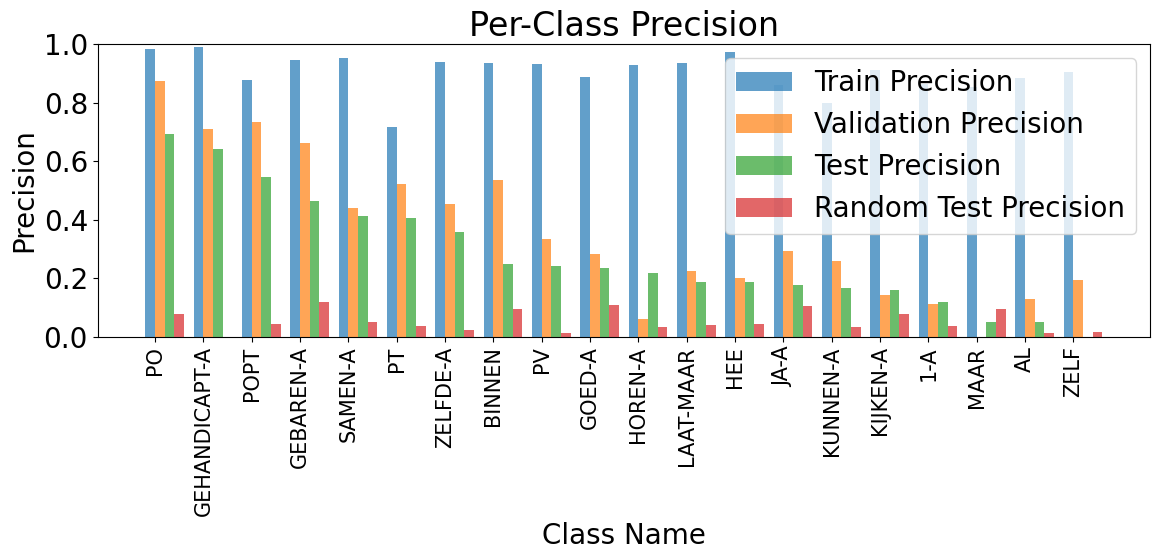

In [60]:
# Plot per-class precision as histograms
last_train_precision = train_precision_per_class[-1]
last_val_precision = val_precision_per_class[-1]
last_test_precision = test_precision_per_class
last_random_test_precision = random_test_precision_per_class

bar_width = 0.20
indices = np.arange(num_classes)

sorted_indices = np.argsort(test_precision_per_class)[::-1]  # Sort in descending order
sorted_train_precision = np.array(last_train_precision)[sorted_indices]
sorted_val_precision = np.array(last_val_precision)[sorted_indices]
sorted_test_precision = np.array(last_test_precision)[sorted_indices]
sorted_random_test_precision = np.array(last_random_test_precision)[sorted_indices]
reverse_dict = {v: k for k, v in labels_dict.items()}
sorted_labels = [reverse_dict[key] for key in sorted_indices]

plt.figure(figsize=(12, 6))
plt.bar(np.arange(len(sorted_indices)), sorted_train_precision, bar_width, label='Train Precision', alpha=0.7)
plt.bar(np.arange(len(sorted_indices)) + bar_width, sorted_val_precision, bar_width, label='Validation Precision', alpha=0.7)
plt.bar(np.arange(len(sorted_indices)) + 2*bar_width, sorted_test_precision, bar_width, label='Test Precision', alpha=0.7)
plt.bar(np.arange(len(sorted_indices)) + 3*bar_width, sorted_random_test_precision, bar_width, label='Random Test Precision', alpha=0.7)
plt.title('Per-Class Precision')
plt.xlabel('Class Index' if labels_dict is None else 'Class Name')
plt.ylabel('Precision')
plt.ylim(0, 1)
plt.xticks(np.arange(len(sorted_indices)) + bar_width / 2, sorted_labels, rotation=90, fontsize=15)
plt.legend()
plt.tight_layout()
plt.savefig(modelweights+'/RANDOM Train-Val-Test Precision Per Class'+epoch+'.png')
plt.show()

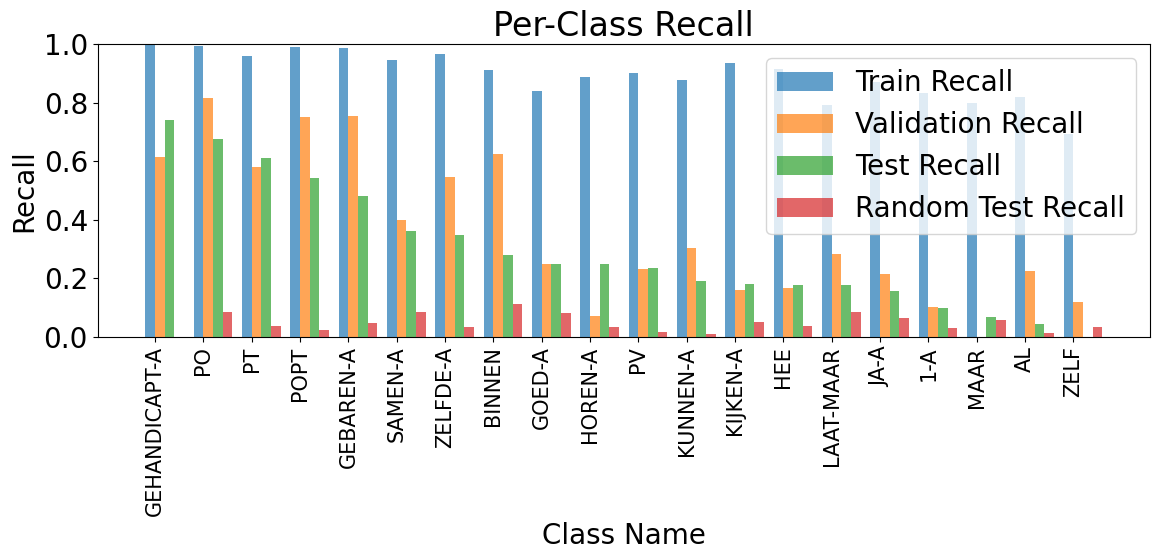

In [61]:
# Plot per-class recall as histograms
last_train_recall = train_recall_per_class[-1]
last_val_recall = val_recall_per_class[-1]
last_test_recall = test_recall_per_class
last_random_test_recall = random_test_recall_per_class

bar_width = 0.20
indices = np.arange(num_classes)

sorted_indices = np.argsort(test_recall_per_class)[::-1]  # Sort in descending order
sorted_train_recall = np.array(last_train_recall)[sorted_indices]
sorted_val_recall = np.array(last_val_recall)[sorted_indices]
sorted_test_recall = np.array(last_test_recall)[sorted_indices]
sorted_random_test_recall = np.array(last_random_test_recall)[sorted_indices]
reverse_dict = {v: k for k, v in labels_dict.items()}
sorted_labels = [reverse_dict[key] for key in sorted_indices]

plt.figure(figsize=(12, 6))
plt.bar(np.arange(len(sorted_indices)), sorted_train_recall, bar_width, label='Train Recall', alpha=0.7)
plt.bar(np.arange(len(sorted_indices)) + bar_width, sorted_val_recall, bar_width, label='Validation Recall', alpha=0.7)
plt.bar(np.arange(len(sorted_indices)) + 2*bar_width, sorted_test_recall, bar_width, label='Test Recall', alpha=0.7)
plt.bar(np.arange(len(sorted_indices)) + 3*bar_width, sorted_random_test_recall, bar_width, label='Random Test Recall', alpha=0.7)
plt.title('Per-Class Recall')
plt.xlabel('Class Index' if labels_dict is None else 'Class Name')
plt.ylabel('Recall')
plt.ylim(0, 1)
plt.xticks(np.arange(len(sorted_indices)) + bar_width / 2, sorted_labels, rotation=90, fontsize=15)
plt.legend()
plt.tight_layout()
plt.savefig(modelweights+'/RANDOM Train-Val-Test Recall Per Class'+epoch+'.png')
plt.show()

### Qualitative Analysis

In [62]:
import torch
from tqdm import tqdm
import numpy as np

def test_model(model, test_loader_combined, device, num_classes):
    model.eval()
    running_loss = 0.0
    correct_preds = 0
    total_preds = 0

    precision_per_class = np.zeros(num_classes)
    recall_per_class = np.zeros(num_classes)
    correct_per_class = np.zeros(num_classes)  # Store correct predictions per class
    total_per_class = np.zeros(num_classes)  # Store total samples per class

    criterion = torch.nn.CrossEntropyLoss()  # Assuming cross-entropy loss

    with torch.no_grad():
        for (inputs_kp, inputs_mae, labels) in tqdm(test_loader_combined, desc="Testing"):
            inputs_mae, inputs_kp, labels = inputs_mae.to(device), inputs_kp.to(device), labels.to(device)

            outputs = model(inputs_kp, inputs_mae)  # Assuming the model takes both inputs
            loss = criterion(outputs, labels)

            # Update running loss
            running_loss += loss.item() * inputs_mae.size(0)

            # Compute predictions
            preds = torch.argmax(outputs, dim=1)

            correct_preds += (preds == labels).sum().item()
            total_preds += labels.size(0)

            # Compute per-class metrics
            overall_precision, class_precision, overall_recall, class_recall = calculate_metrics(preds, labels, num_classes)
            precision_per_class += class_precision
            recall_per_class += class_recall

            # Update per-class accuracy tracking
            for i in range(num_classes):
                correct_per_class[i] += ((preds == i) & (labels == i)).sum().item()
                total_per_class[i] += (labels == i).sum().item()

    # Calculate final metrics
    test_loss = running_loss / len(test_loader_combined.dataset)
    test_acc = correct_preds / total_preds
    test_precision = precision_per_class.mean() / len(test_loader_combined)
    test_recall = recall_per_class.mean() / len(test_loader_combined)
    test_precision_per_class = precision_per_class / len(test_loader_combined)
    test_recall_per_class = recall_per_class / len(test_loader_combined)
    average_test_precision_per_class = sum(test_precision_per_class) / num_classes
    average_test_recall_per_class = sum(test_recall_per_class) / num_classes

    # Compute per-class accuracy in dict format
    accuracy_per_class_dict = {i: correct_per_class[i] / total_per_class[i] if total_per_class[i] > 0 else 0
                               for i in range(num_classes)}

    print(f"Test Summary:")
    print(f"Test Loss: {test_loss:.4f}, Accuracy: {test_acc:.4f}, Precision: {test_precision:.4f}, Recall: {test_recall:.4f}")
    print(f"Per-Class Precision: {test_precision_per_class}")
    print(f"Per-Class Recall: {test_recall_per_class}")
    print(f"Per-Class Accuracy: {accuracy_per_class_dict}")

    return test_loss, test_acc, test_precision, test_precision_per_class, average_test_precision_per_class, test_recall, test_recall_per_class, average_test_recall_per_class, accuracy_per_class_dict


def test_random_baseline(test_loader_combined, device, num_classes):
    running_loss = 0.0
    correct_preds = 0
    total_preds = 0
    precision_per_class = np.zeros(num_classes)
    recall_per_class = np.zeros(num_classes)
    accuracy_per_class = np.zeros(num_classes)  # Added accuracy per class
    class_counts = np.zeros(num_classes)  # To track the number of samples per class

    criterion = torch.nn.CrossEntropyLoss()  # Assuming cross-entropy loss

    with torch.no_grad():
        for (inputs_kp, inputs_mae, labels) in tqdm(test_loader_combined, desc="Testing Random Baseline"):
            labels = labels.to(device)

            # Generate random predictions based on the number of classes
            batch_size = labels.size(0)
            random_preds = torch.randint(0, num_classes, (batch_size,), device=device)

            # Compute loss (random predictions vs. actual labels)
            loss = criterion(torch.randn(batch_size, num_classes, device=device), labels)  # Use random logits

            # Update running loss
            running_loss += loss.item() * batch_size

            # Compute overall accuracy
            correct_preds += (random_preds == labels).sum().item()
            total_preds += batch_size

            # Compute per-class metrics
            overall_precision, class_precision, overall_recall, class_recall = calculate_metrics(random_preds, labels, num_classes)
            precision_per_class += class_precision
            recall_per_class += class_recall

            # Update per-class accuracy
            for i in range(num_classes):
                class_mask = (labels == i)
                class_counts[i] += class_mask.sum().item()
                accuracy_per_class[i] += (random_preds[class_mask] == labels[class_mask]).sum().item()

    # Normalize per-class accuracy
    accuracy_per_class = np.divide(accuracy_per_class, class_counts, where=class_counts > 0)

    # Calculate final metrics
    test_loss = running_loss / len(test_loader_combined.dataset)
    test_acc = correct_preds / total_preds
    test_precision = precision_per_class.mean() / len(test_loader_combined)
    test_recall = recall_per_class.mean() / len(test_loader_combined)
    test_precision_per_class = precision_per_class / len(test_loader_combined)
    test_recall_per_class = recall_per_class / len(test_loader_combined)
    average_test_precision_per_class = sum(test_precision_per_class) / num_classes
    average_test_recall_per_class = sum(test_recall_per_class) / num_classes
    average_test_accuracy_per_class = sum(accuracy_per_class) / num_classes  # Compute the average accuracy per class

    # Compute per-class accuracy in dict format
    accuracy_per_class_dict = {i: accuracy_per_class[i] for i in range(num_classes)}

    print(f"Test Summary:")
    print(f"Test Loss: {test_loss:.4f}, Accuracy: {test_acc:.4f}, Precision: {test_precision:.4f}, Recall: {test_recall:.4f}")
    print(f"Per-Class Precision: {test_precision_per_class}")
    print(f"Per-Class Recall: {test_recall_per_class}")
    print(f"Per-Class Accuracy: {accuracy_per_class_dict}")

    return test_loss, test_acc, test_precision, test_precision_per_class, average_test_precision_per_class, test_recall, test_recall_per_class, average_test_recall_per_class, accuracy_per_class_dict, average_test_accuracy_per_class



epoch = "80"

# Choose which epoch of model weights we want to test
path_to_model_weights = modelweights + "/epoch" + epoch

# Load best model weights
model.load_state_dict(torch.load(path_to_model_weights))

# Test the model
test_loss, test_acc, test_precision, test_precision_per_class, average_test_precision_per_class, test_recall, test_recall_per_class, average_test_recall_per_class, test_accuracy_per_class = test_model(
    model, test_loader, device, num_classes)

# Test the model
random_test_loss, random_test_acc, random_test_precision, random_test_precision_per_class, random_average_test_precision_per_class, random_test_recall, random_test_recall_per_class, random_average_test_recall_per_class, random_test_accuracy_per_class, random_average_test_accuracy_per_class = test_random_baseline(
    test_loader, device, num_classes
)

Testing: 100%|██████████| 30/30 [00:03<00:00,  7.52it/s]


Test Summary:
Test Loss: 3.3355, Accuracy: 0.3718, Precision: 0.2766, Recall: 0.2827
Per-Class Precision: [0.08055556 0.07555556 0.27777778 0.49166667 0.64722222 0.24722222
 0.13888889 0.19722222 0.14055556 0.12777778 0.23444444 0.19722222
 0.09555556 0.70555556 0.52666667 0.41111112 0.19166667 0.27777778
 0.08333333 0.385     ]
Per-Class Recall: [0.07611111 0.07222222 0.27777778 0.47444445 0.66277778 0.29277778
 0.16111111 0.23055556 0.13388889 0.09611111 0.21666667 0.16166667
 0.12222222 0.66944445 0.56166667 0.54444445 0.2        0.275
 0.06666667 0.35777778]
Per-Class Accuracy: {0: np.float64(0.11904761904761904), 1: np.float64(0.16666666666666666), 2: np.float64(0.42424242424242425), 3: np.float64(0.5833333333333334), 4: np.float64(0.8478260869565217), 5: np.float64(0.2711864406779661), 6: np.float64(0.14285714285714285), 7: np.float64(0.34), 8: np.float64(0.23404255319148937), 9: np.float64(0.2), 10: np.float64(0.22916666666666666), 11: np.float64(0.22641509433962265), 12: np.flo

Testing Random Baseline: 100%|██████████| 30/30 [00:03<00:00,  7.60it/s]

Test Summary:
Test Loss: 3.4352, Accuracy: 0.0427, Precision: 0.0340, Recall: 0.0338
Per-Class Precision: [0.03333333 0.         0.01111111 0.03333333 0.02333333 0.06666667
 0.02222222 0.03333333 0.025      0.06666667 0.00666667 0.03333333
 0.05476191 0.         0.06944444 0.05555556 0.05       0.03333333
 0.01777778 0.04444444]
Per-Class Recall: [0.01666667 0.         0.01111111 0.02333333 0.04444444 0.02333333
 0.01666667 0.03333333 0.05       0.06111111 0.03333333 0.01111111
 0.1        0.         0.03444444 0.07222222 0.06666667 0.00833333
 0.02777778 0.04166667]
Per-Class Accuracy: {0: np.float64(0.023809523809523808), 1: np.float64(0.0), 2: np.float64(0.030303030303030304), 3: np.float64(0.041666666666666664), 4: np.float64(0.043478260869565216), 5: np.float64(0.03389830508474576), 6: np.float64(0.04081632653061224), 7: np.float64(0.02), 8: np.float64(0.0425531914893617), 9: np.float64(0.06666666666666667), 10: np.float64(0.020833333333333332), 11: np.float64(0.018867924528301886

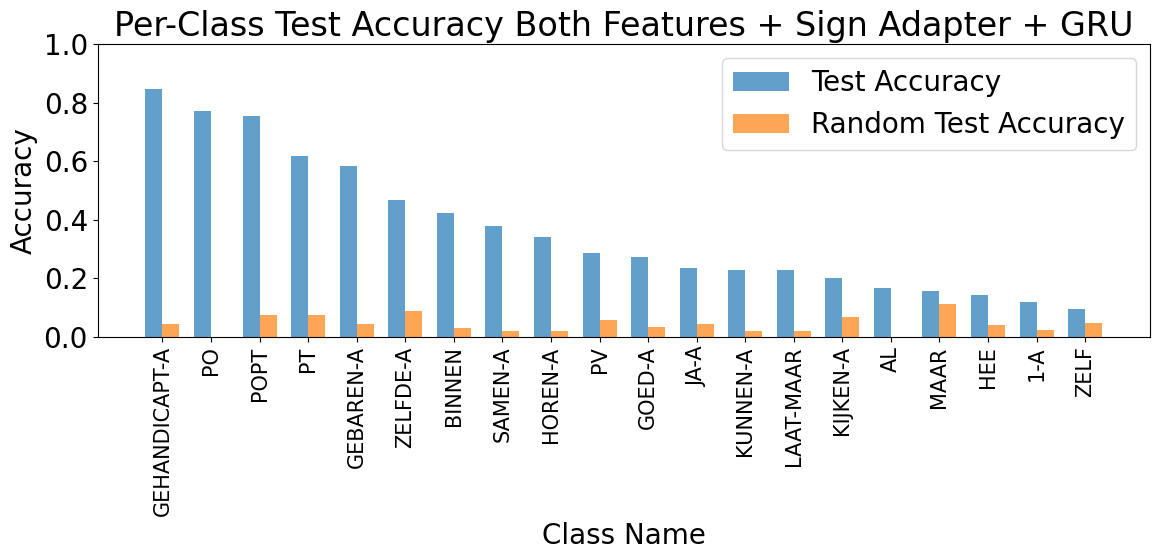

In [63]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming last_test_accuracy is a dictionary with class index as keys and accuracy as values
last_test_accuracy = test_accuracy_per_class  # This is now a dict
random_last_test_accuracy = random_test_accuracy_per_class  # This is also a dict

bar_width = 0.35
indices = np.arange(len(last_test_accuracy))  # Length of the dictionary

# Sort the dictionary based on accuracy (values) in descending order
sorted_accuracy = {k: v for k, v in sorted(last_test_accuracy.items(), key=lambda item: item[1], reverse=True)}
sorted_random_accuracy = {k: v for k, v in sorted(random_last_test_accuracy.items(), key=lambda item: item[1], reverse=True)}

# Extract sorted indices and accuracies
sorted_indices = list(sorted_accuracy.keys())  # Sorted class indices based on accuracy
sorted_test_accuracy = list(sorted_accuracy.values())  # Sorted test accuracies
sorted_random_test_accuracy = [sorted_random_accuracy[i] for i in sorted_indices]  # Align random accuracy with sorted indices

# Reverse the dictionary to map indices to labels
reverse_dict = {v: k for k, v in labels_dict.items()}
sorted_labels = [reverse_dict[key] for key in sorted_indices]

# Plotting the data
plt.figure(figsize=(12, 6))
plt.bar(np.arange(len(sorted_indices)), sorted_test_accuracy, bar_width, label='Test Accuracy', alpha=0.7)
plt.bar(np.arange(len(sorted_indices)) + bar_width, sorted_random_test_accuracy, bar_width, label='Random Test Accuracy', alpha=0.7)
plt.title('Per-Class Test Accuracy Both Features + Sign Adapter + ' + model_type)
plt.xlabel('Class Index' if labels_dict is None else 'Class Name')
plt.ylabel('Accuracy')
plt.ylim(0, 1)

# Update x-axis labels with class names if labels_dict is available
plt.xticks(np.arange(len(sorted_indices)) + bar_width / 2, sorted_labels, rotation=90, fontsize=15)

plt.legend()
plt.tight_layout()
plt.savefig(modelweights+'/RANDOM Test Accuracy Per Class'+epoch+'.png')
plt.show()
